In [90]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
import pandas_datareader as pdr
from datetime import datetime


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


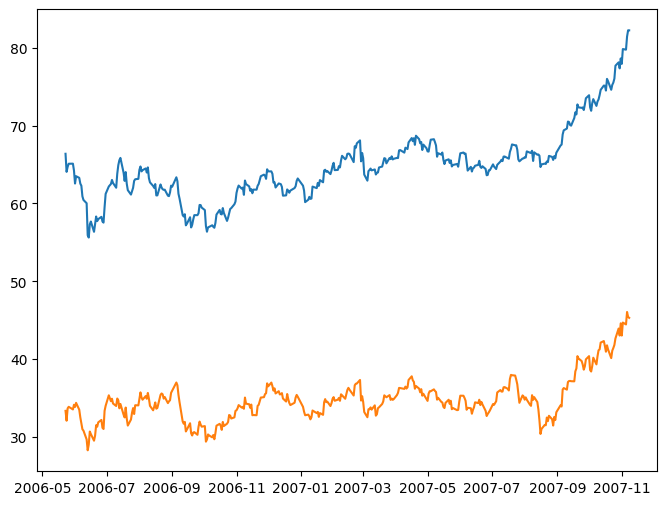

In [91]:
df1 = yf.download('GLD' , datetime(2006,5, 23), datetime(2007, 11, 9))['Adj Close']
df2 = yf.download('GDX', datetime(2006,5, 23), datetime(2007, 11, 9))['Adj Close']
df = pd.merge(df1, df2, on='Date', suffixes=('_GLD', '_GDX'))

train = np.arange(0, 252)
test = np.arange(train.shape[0], df.shape[0])

plt.rcParams['figure.figsize'] = 8, 6
plt.plot(df)


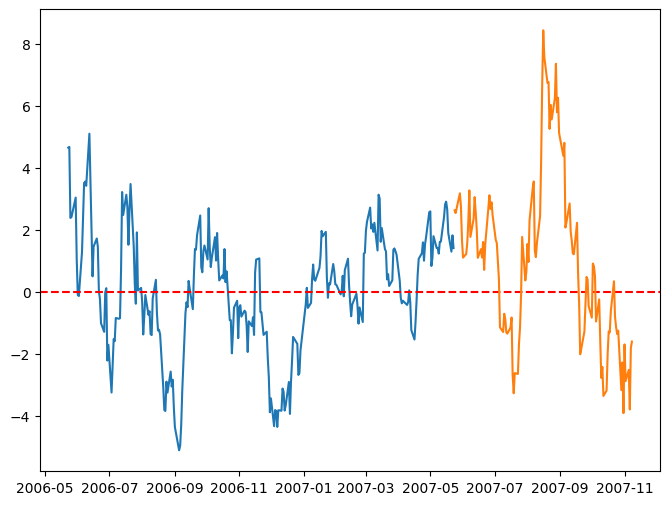

In [110]:
model = sm.OLS(df.loc[:, 'Adj Close_GLD'].iloc[train], df.loc[:, 'Adj Close_GDX'].iloc[train])
result = model.fit()
b = result.params[0]

spread = df.loc[:,'Adj Close_GLD'] - b * df.loc[:,'Adj Close_GDX']
plt.plot(spread.iloc[train])
plt.axhline(0, linestyle='--', color='r')
plt.plot(spread.iloc[test])


In [93]:
from statsmodels.tsa.stattools import adfuller
adfuller(spread)

(-4.023996403498497,
 0.0012899422054298516,
 0,
 369,
 {'1%': -3.448196541708585,
  '5%': -2.869404683789669,
  '10%': -2.5709597356805545},
 891.7440485571076)

In [94]:
from statsmodels.tsa.stattools import coint
if coint(df1,df2)[1] < 0.05:
    print ('pvalue is: ', coint(df1,df2)[1],  'the series are cointegrated')
else:
    print ('pvalue is: ', coint(df1,df2)[1],  'the series are not cointegrated')


pvalue is:  0.033941672019575646 the series are cointegrated


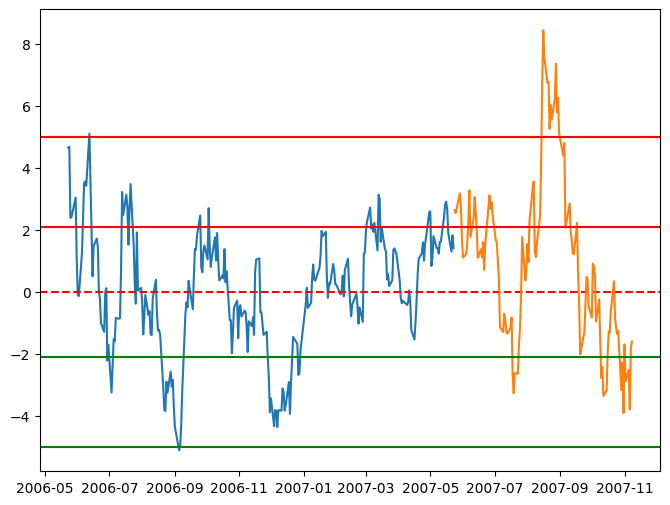

In [122]:
spreadMean = np.mean(spread.iloc[train])
spreadStd = np.std(spread.iloc[train])
df['zscore'] = (spread - spreadMean) / spreadStd
df['position_GLD_long'] = 0
df['position_GDX_long'] = 0
df['position_GDX_short'] = 0
df['position_GLD_short'] = 0

#short spread
df.loc[df.zscore >=2, ('position_GLD_short', 'position_GDX_short' ) ] = [-1 , 1]

#buy spread
df.loc[df.zscore <=-2, ('position_GLD_long', 'position_GDX_long' ) ] = [1 , -1]

#exit short spread
df.loc[df.zscore <=1, ('position_GLD_short', 'position_GDX_short' ) ] = 0

#exit long spread
df.loc[df.zscore >=-1, ('position_GLD_long', 'position_GDX_long' ) ] = 0
df.fillna(method='ffill', inplace=True)

plt.plot(spread.iloc[train])
plt.axhline(0, linestyle='--', color='r')
plt.plot(spread.iloc[test])
plt.axhline(5, color='r') #95.5% , z = 2
plt.axhline(2.1, color='r') #68%, z = 1
plt.axhline(-2.1, color='g')
plt.axhline(-5, color='g')

position_long = df.loc[:, ('position_GLD_long', 'position_GDX_long')]
position_short = df.loc[:, ('position_GLD_short', 'position_GDX_short')]

position = np.array(position_long) + np.array(position_short)
position=pd.DataFrame(position)



In [96]:
dailyret = df.loc[:, ( 'Adj Close_GLD', 'Adj Close_GDX')].pct_change()

pnl=(np.array(position.shift())*np.array(dailyret)).sum(axis=1)


In [97]:
sharpetrain = np.sqrt(624) * np.mean(pnl[train[1:]]) / np.std(pnl[train[1:]])
sharpetrain

3.3383369166063246

In [98]:
sharpetest = np.sqrt(624) * np.mean(pnl[test]) / np.std(pnl[test])
sharpetest

1.6950522874633192

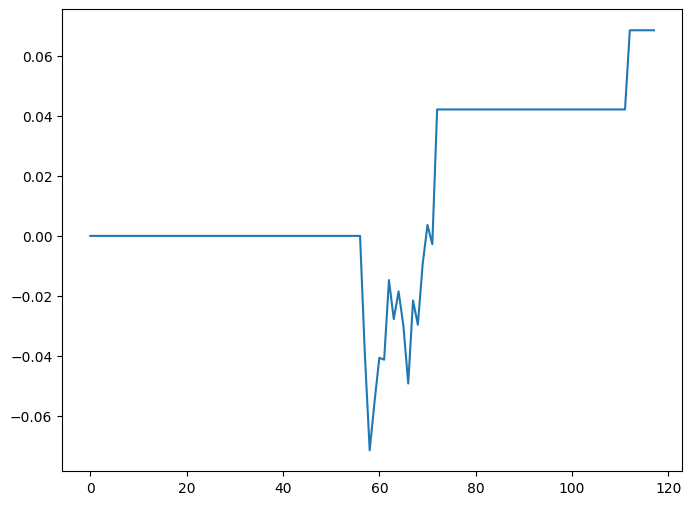

In [99]:
plt.plot(np.cumsum(pnl[test]))


In [105]:
df['zscore'].loc['2007-08-20':]

Date
2007-08-20    3.432766
2007-08-21    3.448988
2007-08-22    2.671192
2007-08-23    3.069299
2007-08-24    2.826558
2007-08-27    3.178960
2007-08-28    3.749834
2007-08-29    2.948543
2007-08-30    3.187033
2007-08-31    2.601332
2007-09-04    2.227450
2007-09-05    2.440050
2007-09-06    1.037388
2007-09-07    1.125385
2007-09-10    1.436466
2007-09-11    0.968442
2007-09-12    0.820222
2007-09-13    0.608111
2007-09-14    0.595377
2007-09-17    1.115926
2007-09-18    0.275452
2007-09-19   -0.223864
2007-09-20   -1.061539
2007-09-21   -0.971807
2007-09-24   -0.684058
2007-09-25   -0.230747
2007-09-26    0.220067
2007-09-27    0.177454
2007-09-28   -0.261359
2007-10-01   -0.454943
2007-10-02    0.441904
2007-10-03    0.395036
2007-10-04    0.231314
2007-10-05   -0.519138
2007-10-08   -0.153082
2007-10-09   -0.846195
2007-10-10   -1.453596
2007-10-11   -1.271475
2007-10-12   -1.751970
2007-10-15   -1.662081
2007-10-16   -1.060295
2007-10-17   -0.683111
2007-10-18   -0.700152
2007-1

In [107]:
spread.loc['2007-08-20':]

Date
2007-08-20    6.729928
2007-08-21    6.761485
2007-08-22    5.248453
2007-08-23    6.022883
2007-08-24    5.550682
2007-08-27    6.236203
2007-08-28    7.346715
2007-08-29    5.787979
2007-08-30    6.251908
2007-08-31    5.112554
2007-09-04    4.385249
2007-09-05    4.798816
2007-09-06    2.070242
2007-09-07    2.241422
2007-09-10    2.846561
2007-09-11    1.936123
2007-09-12    1.647793
2007-09-13    1.235176
2007-09-14    1.210405
2007-09-17    2.223021
2007-09-18    0.588061
2007-09-19   -0.383249
2007-09-20   -2.012763
2007-09-21   -1.838209
2007-09-24   -1.278457
2007-09-25   -0.396640
2007-09-26    0.480323
2007-09-27    0.397428
2007-09-28   -0.456188
2007-10-01   -0.832763
2007-10-02    0.911857
2007-10-03    0.820686
2007-10-04    0.502201
2007-10-05   -0.957641
2007-10-08   -0.245558
2007-10-09   -1.593859
2007-10-10   -2.775426
2007-10-11   -2.421149
2007-10-12   -3.355848
2007-10-15   -3.180988
2007-10-16   -2.010344
2007-10-17   -1.276615
2007-10-18   -1.309763
2007-1